In [2]:
from src.densite_function import *
from src.gaussian_simulation import *
from src.estimators2 import *
from src.vraisemblance import *
import numpy as np
from numpy.linalg import norm 
import matplotlib.pylab as plt

# Préalable

On tire $\mathbf{x}$ et $\theta$ au hasard dans $\mathbb{R}^{20}$ et on fixe les paramètres optimaux $A^*$ et $b^*$ (voir Rainforth 2018). Puis, on génére les paramètres $A$ et $b$ en ajoutant un bruit gaussien.

In [3]:
np.random.seed(12345)

theta=simulate_gaussian_vector(mu=np.array([0]*20), sigma=np.identity(20))
z=simulate_gaussian_vector(mu=theta, sigma=np.identity(20))
x=simulate_gaussian_vector(mu=z, sigma=np.identity(20)) #on sait simuler x|z

A_optimal=np.identity(20)*0.5
b_optimal=theta/2

A=A_optimal+simulate_gaussian_vector(mu=np.array([0]*20), sigma=0.01*np.identity(20))
b=b_optimal+simulate_gaussian_vector(mu=np.array([0]*20), sigma=0.01*np.identity(20))

# Estimateurs de la log-vraisemblance

## Comparaison entre estimateurs et vraie log-vraisemblance au point x

On prend $k=6$ pour l'estimateur IAWE, $l=0$ pour les autres.

In [4]:
np.random.seed(589)
print("Vraie valeur de la log-vraisemblance au point x: {}".format(np.around(log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE de la log-vraisemblance: {}".format(np.around(importance_sampling_logvraisemblance(k=6, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=0), decimals=2)))
print("Estimateur ML-SS de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_logvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))
print("Estimateur ML-RR de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_logvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))

Vraie valeur de la log-vraisemblance au point x: -35.96
Estimateur IAWE de la log-vraisemblance: -55.65
Estimateur SUMO de la log-vraisemblance: -49.55
Estimateur ML-SS de la log-vraisemblance: -42.09
Estimateur ML-RR de la log-vraisemblance: -59.55


On prend $k=6$ pour l'estimateur IAWE, $l=6$ pour les autres.

In [5]:
np.random.seed(589)
print("Vraie valeur de la log-vraisemblance au point x: {}".format(np.around(log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE de la log-vraisemblance: {}".format(np.around(importance_sampling_logvraisemblance(k=6, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=6), decimals=2)))
print("Estimateur ML-SS de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_logvraisemblance(x, theta, A, b, r=0.6, l=6), decimals=2)))
print("Estimateur ML-RR de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_logvraisemblance(x, theta, A, b, r=0.6, l=6), decimals=2)))

Vraie valeur de la log-vraisemblance au point x: -35.96
Estimateur IAWE de la log-vraisemblance: -55.65
Estimateur SUMO de la log-vraisemblance: -50.41
Estimateur ML-SS de la log-vraisemblance: -69.13
Estimateur ML-RR de la log-vraisemblance: -64.37


## Coût des estimateurs

On suppose que les estimateurs ML-SS, ML-RR et SUMO contiennent une période de chauffe $l$.
* IWAE: pour produire l'estimateur, on sample $k$ variables aléatoires. Le coût est déterministe: $\mathbb{E}[C_{IWAE}]=C_{IWAE}=k$
* ML-SS: pour produire l'estimateur, on sample $2^{K+l+1}$ variables aléatoires, où $K \sim \mathcal{G}(0,6) $. Donc $C_{ML-SS}=2^{K+l+1}$ est aléatoire.
$\mathbb{E}(C_{ML-SS})=6.2^l$
* ML-RR: pour produire l'estimateur, on sample $\sum_{k=0}^{K} 2^{k+l+1}$ variables. Donc $C_{ML-RR}=\sum_{k=0}^K 2^{k+l+1}$. $\mathbb{E}(C_{ML-RR})=6.2^l$
* SUMO: pour produire l'estimateur, on sample $\sum_{k=0}^K(k+l+2)=\frac{K(K+1)}{2}+(l+2)K$ variables. Donc, $C_{SUMO}=\frac{K(K+1)}{2}+(l+2)K$. $\mathbb{E}(C_{SUMO})=\frac{55}{9}+\frac{5}{3}l$

## Procédure de Monte Carlo

On met en place une procédure de Monte Carlo pour estimer le biais et la variance des estimateurs, en fonction du coût computationel $l$ pour chaque méthode ($l$: le nombre d'observations générées selon la loi de proposition pour IAWE, $l$: limite du support de $K$ pour les autres estimateurs).

L'algorithme est le suivant: (on confond $k$ et $l$ pour plus de simplicité)

Pour $l$ allant de 6 à 384, faire:

Pour m allant de 1 à M, faire:

Calculer chaque estimateur au point $\mathbb{x}$: $estimateur_{m,l}$

Calculer:

\begin{equation}

    biais_{M,l}=\frac{1}{M} \sum_{m=1}^{M} estimateur_{m,l} - l(x;\theta)

\end{equation}

\begin{equation}

    Var_{M,l}=\frac{1}{M} \sum_{m=1}^{M}( estimateur_{m,l} - \frac{1}{M} \sum_{m=1}^{M} estimateur_{m,l})^{2}

\end{equation}

Fin pour

Fin pour

Retourner $biais_{M,6}, ..., biais_{M,384}, Var_{M,6}, ..., Var_{M,6384}$

Les auteurs de l'article prennent $M=1000$.

In [21]:
def procedure_MC_logvraisemblance(M, x, theta, A, b, L):

    biais_IWAE_M={}
    biais_SUMO_M={}
    biais_SS_M={}
    biais_RR_M={}

    var_IWAE_M={}
    var_SUMO_M={}
    var_SS_M={}
    var_RR_M={}

    l=1
    while l<=L:
        m=1
        estimations_IWAE_M_l=np.array([])
        estimations_SUMO_M_l=np.array([])
        estimations_SS_M_l=np.array([])
        estimations_RR_M_l=np.array([])


        while m<=M:
            log_vraisemblance_estim_IWAE=importance_sampling_logvraisemblance(k=l*64, theta=theta, A=A, b=b, x=x)
            log_vraisemblance_estim_SUMO=estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l*38)
            log_vraisemblance_estim_SS=estimateur_ML_SS_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            log_vraisemblance_estim_RR=estimateur_ML_RR_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)


            estimations_IWAE_M_l= np.append(estimations_IWAE_M_l, log_vraisemblance_estim_IWAE)
            estimations_SUMO_M_l=np.append(estimations_SUMO_M_l, log_vraisemblance_estim_SUMO)
            estimations_SS_M_l=np.append(estimations_SS_M_l, log_vraisemblance_estim_SS)
            estimations_RR_M_l=np.append(estimations_RR_M_l, log_vraisemblance_estim_RR)
            m+=1
        
        biais_IWAE_M_l=np.mean(estimations_IWAE_M_l)-log_vraisemblance(x=x, theta=theta)
        biais_SUMO_M_l=np.mean(estimations_SUMO_M_l)-log_vraisemblance(x=x, theta=theta)
        biais_SS_M_l=np.mean(estimations_SS_M_l)-log_vraisemblance(x=x, theta=theta)
        biais_RR_M_l=np.mean(estimations_RR_M_l)-log_vraisemblance(x=x, theta=theta)

        var_IWAE_M_l=np.var(estimations_IWAE_M_l)
        var_SUMO_M_l=np.var(estimations_SUMO_M_l)
        var_SS_M_l=np.var(estimations_SS_M_l)
        var_RR_M_l=np.var(estimations_RR_M_l)

        biais_IWAE_M[l]=biais_IWAE_M_l
        biais_SUMO_M[l]=biais_SUMO_M_l
        biais_SS_M[l]=biais_SS_M_l
        biais_RR_M[l]=biais_RR_M_l

        var_IWAE_M[l]=var_IWAE_M_l
        var_SUMO_M[l]=var_SUMO_M_l
        var_SS_M[l]=var_SS_M_l
        var_RR_M[l]=var_RR_M_l

        l+=1

    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M

In [22]:
np.random.seed(123)

biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M = procedure_MC_logvraisemblance(M=200, 
                                                                                                                               L=6, 
                                                                                                                               x=x, 
                                                                                                                               theta=theta, 
                                                                                                                               A=A, 
                                                                                                                               b=b)


C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\2223480491.py:35: RuntimeWarning: invalid value encountered in log
  biais_IWAE_M_l=np.log(np.mean(estimations_IWAE_M_l)-log_vraisemblance(x=x, theta=theta))
C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\2223480491.py:36: RuntimeWarning: invalid value encountered in log
  biais_SUMO_M_l=np.log(np.mean(estimations_SUMO_M_l)-log_vraisemblance(x=x, theta=theta))
C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\2223480491.py:38: RuntimeWarning: invalid value encountered in log
  biais_RR_M_l=np.log(np.mean(estimations_RR_M_l)-log_vraisemblance(x=x, theta=theta))
C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\2223480491.py:37: RuntimeWarning: invalid value encountered in log
  biais_SS_M_l=np.log(np.mean(estimations_SS_M_l)-log_vraisemblance(x=x, theta=theta))


KeyboardInterrupt: 

C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\1289945808.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(l, np.log(np.square(biais_IAWE)), 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\1289945808.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(l, np.log(np.square(biais_SUMO)), 'b', label="Biais au carré de l'estimateur SUMO", color="red")
C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\1289945808.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(l, np.log(np.square(biais_SS)), 'b', label=

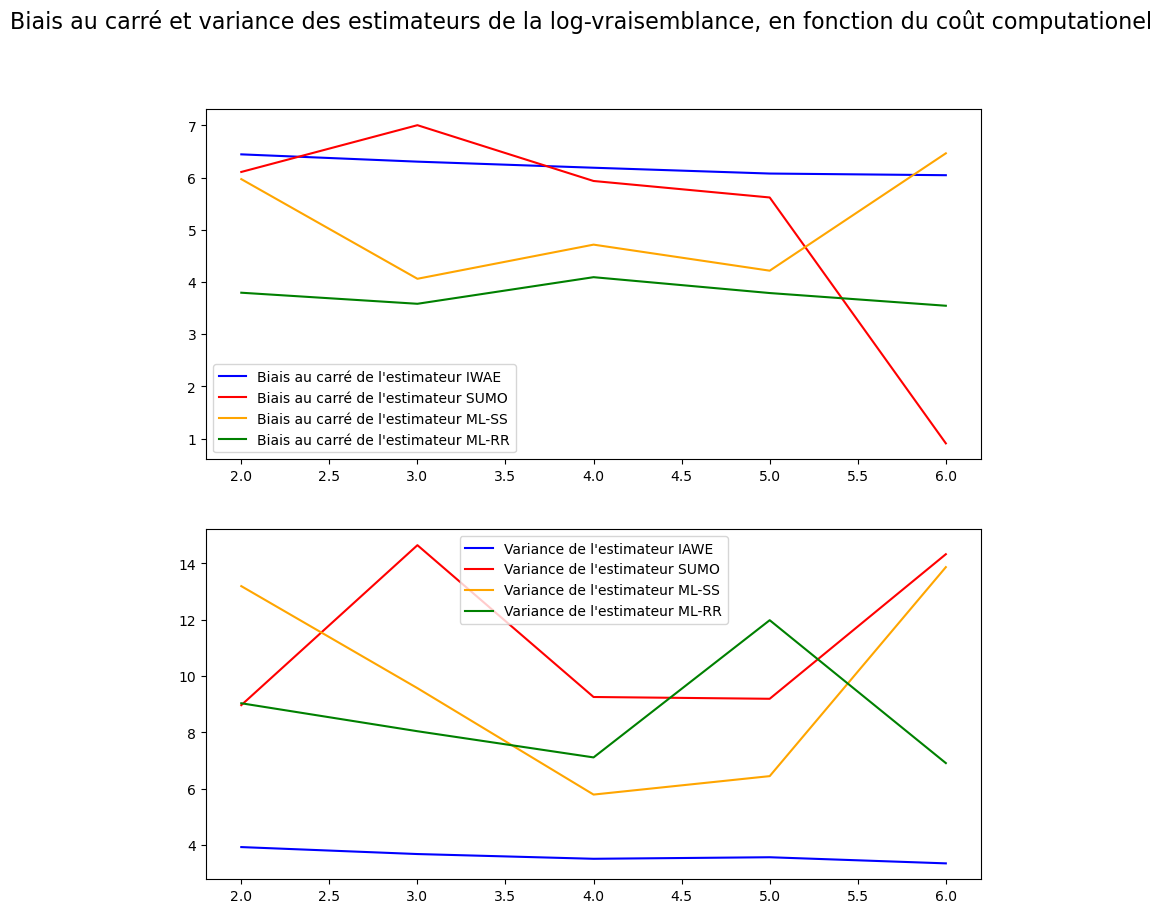

In [25]:
sorted_biais_IWAE_M = sorted(biais_IWAE_M.items())
sorted_biais_SUMO_M = sorted(biais_SUMO_M.items())
sorted_biais_SS_M = sorted(biais_SS_M.items())
sorted_biais_RR_M = sorted(biais_RR_M.items())

sorted_var_IWAE_M = sorted(var_IWAE_M.items())
sorted_var_SUMO_M = sorted(var_SUMO_M.items())
sorted_var_SS_M = sorted(var_SS_M.items())
sorted_var_RR_M = sorted(var_RR_M.items())

l, biais_IAWE = zip(*sorted_biais_IWAE_M)
l, biais_SUMO = zip(*sorted_biais_SUMO_M)
l, biais_SS = zip(*sorted_biais_SS_M)
l, biais_RR = zip(*sorted_biais_RR_M)

l, var_SUMO = zip(*sorted_var_SUMO_M) 
l, var_SS = zip(*sorted_var_SS_M) 
l, var_RR = zip(*sorted_var_RR_M)
l, var_IAWE = zip(*sorted_var_IWAE_M) 

fig, axs = plt.subplots(2,1, figsize=(10, 10))

axs[0].plot(l, np.log(np.square(biais_IAWE)), 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0].plot(l, np.log(np.square(biais_SUMO)), 'b', label="Biais au carré de l'estimateur SUMO", color="red")
axs[0].plot(l, np.log(np.square(biais_SS)), 'b', label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0].plot(l, np.log(np.square(biais_RR)), 'b', label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0].legend()

fig.suptitle('Biais au carré et variance des estimateurs de la log-vraisemblance, en fonction du coût computationel', fontsize=16)

axs[1].plot(l, np.log(var_IAWE), 'b', label="Variance de l'estimateur IAWE", color="blue")
axs[1].plot(l, np.log(var_SUMO), 'b', label="Variance de l'estimateur SUMO", color="red")
axs[1].plot(l, np.log(var_SS), 'b', label="Variance de l'estimateur ML-SS", color="orange")
axs[1].plot(l, np.log(var_RR), 'b', label="Variance de l'estimateur ML-RR", color="green")


axs[1].legend()

plt.show()

# Estimateurs du gradient de la log-vraisemblance

## Comparaison entre estimateurs et vrai gradient au point x

On estime le gradient de la  log-vraisemblance au point $\mathbf{x}$ avec $k=6$ et $l=6$.

In [8]:
#np.random.seed(589)
print("Vraie valeur du gradient de la log-vraisemblance au point x: {}".format(np.around(gradient_log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE du gradient de la log-vraisemblance: {}".format(np.around(importance_sampling_gradientlogvraisemblance(k=6, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO du gradient de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=6), decimals=2)))
print("Estimateur ML-SS du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=6), decimals=2)))
print("Estimateur ML-RR du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=6), decimals=2)))

Vraie valeur du gradient de la log-vraisemblance au point x: [-5.8   0.55  3.41 -3.98 -3.77  0.82  1.36 -0.46  0.66  5.39 -1.29 -1.17
 -4.76 -1.71  0.93 -0.72 -5.63  0.28 -0.61 -0.66]
Estimateur IAWE du gradient de la log-vraisemblance: [-3.09 -1.08 -0.86 -1.74 -1.86 -1.   -1.36  0.23 -2.36  0.1  -1.04 -1.75
 -3.19 -0.35 -0.8  -1.59 -1.66 -0.05 -0.34 -1.57]
Estimateur SUMO du gradient de la log-vraisemblance: [-2.79 -0.35  0.61 -3.17 -1.81 -0.69 -1.03 -0.28  0.01 -0.18 -1.28 -1.8
 -2.05 -2.06 -0.43 -0.79 -3.12 -0.41 -1.5  -2.64]
Estimateur ML-SS du gradient de la log-vraisemblance: [-0.27 -3.44 -0.22 -3.13 -1.88 -0.77 -1.74 -2.25 -1.5  -1.35 -0.17 -0.84
 -3.42 -1.4  -0.62 -2.81 -2.96 -3.46 -1.91 -4.89]
Estimateur ML-RR du gradient de la log-vraisemblance: [ 6449.99 -2293.17 -1588.87 -1291.17 -1377.62 -1035.79 -1640.56 -1135.42
  -792.06  -138.01 -1137.26 -1737.69 -2119.03  -949.28 -2090.6  -2668.7
 -1715.59 -2602.19 -1398.41 -2399.52]


## Procédure de Monte Carlo

Le gradient de la log-vraisemblance ainsi que les différents estimateurs associés sont dans $\mathbb{R}^{20}$. Ainsi, on adapte la définition du biais au carré et de la variance, de sorte à avoir une valeur réelle.

\begin{equation}

    biais_M=\frac{1}{M} \sum_{m=1}^{M} estimateur_m - \nabla_{\theta}l(x;\theta)

\end{equation}

\begin{equation}

    biais^2_M=\lVert biais_M \rVert^2

\end{equation}

\begin{equation}

    Var_M=\frac{1}{M} \sum_{m=1}^{M} \lVert estimateur_m - \frac{1}{M} \sum_{m=1}^{M} estimateur_m \rVert^{2}

\end{equation}

In [14]:
def procedure_MC_gradientlogvraisemblance(M, x, theta, A, b, L):

    biais_IWAE_M={}
    biais_SUMO_M={}
    biais_SS_M={}
    biais_RR_M={}

    var_IWAE_M={}
    var_SUMO_M={}
    var_SS_M={}
    var_RR_M={}

    l=2
    while l<=L:
        m=1
        estimations_IWAE_M_l=np.array([])
        estimations_SUMO_M_l=np.array([])
        estimations_SS_M_l=np.array([])
        estimations_RR_M_l=np.array([])


        while m<=M:
            gradient_log_vraisemblance_estim_IWAE=importance_sampling_gradientlogvraisemblance(k=l, theta=theta, A=A, b=b, x=x)
            gradient_log_vraisemblance_estim_SUMO=estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            gradient_log_vraisemblance_estim_SS=estimateur_ML_SS_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            gradient_log_vraisemblance_estim_RR=estimateur_ML_RR_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            if m==1:
                estimations_IWAE_M_l= np.append(estimations_IWAE_M_l, gradient_log_vraisemblance_estim_IWAE)
                estimations_SUMO_M_l=np.append(estimations_SUMO_M_l, gradient_log_vraisemblance_estim_SUMO)
                estimations_SS_M_l=np.append(estimations_SS_M_l, gradient_log_vraisemblance_estim_SS)
                estimations_RR_M_l=np.append(estimations_RR_M_l, gradient_log_vraisemblance_estim_RR)
            
            else:
                estimations_IWAE_M_l= np.vstack((estimations_IWAE_M_l, gradient_log_vraisemblance_estim_IWAE))
                estimations_SUMO_M_l=np.vstack((estimations_SUMO_M_l, gradient_log_vraisemblance_estim_SUMO))
                estimations_SS_M_l=np.vstack((estimations_SS_M_l, gradient_log_vraisemblance_estim_SS))
                estimations_RR_M_l=np.vstack((estimations_RR_M_l, gradient_log_vraisemblance_estim_RR))
            m+=1
        
        biais_IWAE_M_l=np.mean(estimations_IWAE_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
        biais_SUMO_M_l=np.mean(estimations_SUMO_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
        biais_SS_M_l=np.mean(estimations_SS_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
        biais_RR_M_l=np.mean(estimations_RR_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)

        squared_biais_IWAE_M_l=norm(biais_IWAE_M_l)**2
        squared_biais_SUMO_M_l=norm(biais_SUMO_M_l)**2
        squared_biais_SS_M_l=norm(biais_SS_M_l)**2
        squared_biais_RR_M_l=norm(biais_RR_M_l)**2

        var_IWAE_M_l=np.mean(norm(estimations_IWAE_M_l-np.mean(estimations_IWAE_M_l, axis=0), axis=1)**2)
        var_SUMO_M_l=np.mean(norm(estimations_SUMO_M_l-np.mean(estimations_SUMO_M_l, axis=0), axis=1)**2)
        var_SS_M_l=np.mean(norm(estimations_SS_M_l-np.mean(estimations_SS_M_l, axis=0), axis=1)**2)
        var_RR_M_l=np.mean(norm(estimations_RR_M_l-np.mean(estimations_RR_M_l, axis=0), axis=1)**2)

        biais_IWAE_M[l]=squared_biais_IWAE_M_l
        biais_SUMO_M[l]=squared_biais_SUMO_M_l
        biais_SS_M[l]=squared_biais_SS_M_l
        biais_RR_M[l]=squared_biais_RR_M_l

        var_IWAE_M[l]=var_IWAE_M_l
        var_SUMO_M[l]=var_SUMO_M_l
        var_SS_M[l]=var_SS_M_l
        var_RR_M[l]=var_RR_M_l

        l+=1

    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M

In [18]:
np.random.seed(123)

biais_IWAE_M_gradient, biais_SUMO_M_gradient, biais_SS_M_gradient, biais_RR_M_gradient, var_IWAE_M_gradient, var_SUMO_M_gradient, var_SS_M_gradient, var_RR_M_gradient = procedure_MC_gradientlogvraisemblance(M=500, 
                                                                                                                                                                                                        L=6, 
                                                                                                                                                                                                        x=x, 
                                                                                                                                                                                                        theta=theta, 
                                                                                                                                                                                                        A=A, 
                                                                                                                                                                                                        b=b)

C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\3861908196.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(l, np.log(biais_IAWE_gradient), 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\3861908196.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(l, np.log(biais_SUMO_gradient), 'b', label="Biais au carré de l'estimateur SUMO", color="red")
C:\Users\yanis\AppData\Local\Temp\ipykernel_188712\3861908196.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(l, np.log(biais_SS_gradient), 'b', label="Biais

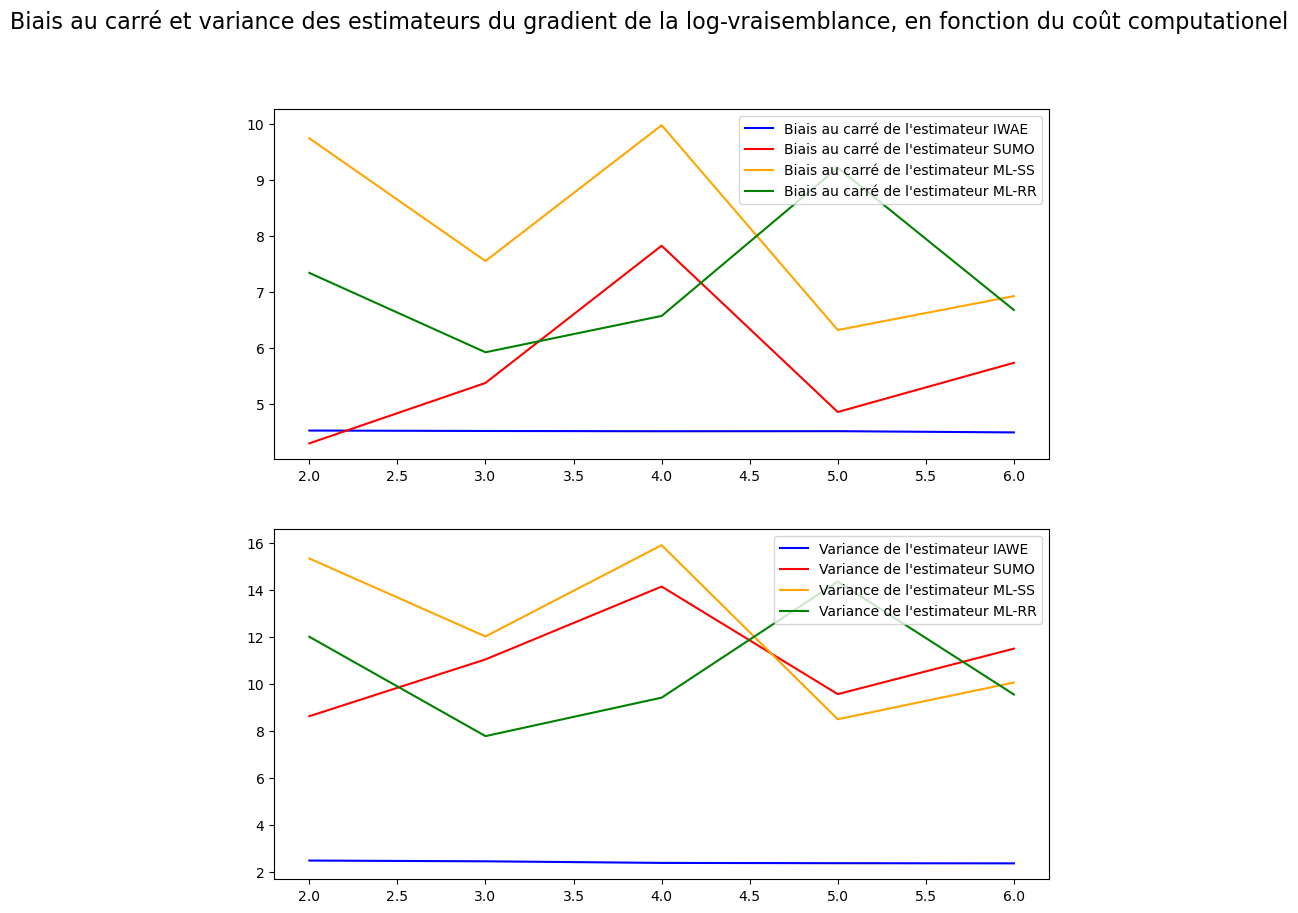

In [29]:
sorted_biais_IWAE_M_gradient = sorted(biais_IWAE_M_gradient.items())
sorted_biais_SUMO_M_gradient = sorted(biais_SUMO_M_gradient.items())
sorted_biais_SS_M_gradient = sorted(biais_SS_M_gradient.items())
sorted_biais_RR_M_gradient = sorted(biais_RR_M_gradient.items())

sorted_var_IWAE_M_gradient = sorted(var_IWAE_M_gradient.items())
sorted_var_SUMO_M_gradient = sorted(var_SUMO_M_gradient.items())
sorted_var_SS_M_gradient = sorted(var_SS_M_gradient.items())
sorted_var_RR_M_gradient = sorted(var_RR_M_gradient.items())

l, biais_IAWE_gradient = zip(*sorted_biais_IWAE_M_gradient)
l, biais_SUMO_gradient = zip(*sorted_biais_SUMO_M_gradient)
l, biais_SS_gradient = zip(*sorted_biais_SS_M_gradient)
l, biais_RR_gradient = zip(*sorted_biais_RR_M_gradient)

l, var_IAWE_gradient = zip(*sorted_var_IWAE_M_gradient) 
l, var_SUMO_gradient = zip(*sorted_var_SUMO_M_gradient) 
l, var_SS_gradient = zip(*sorted_var_SS_M_gradient) 
l, var_RR_gradient = zip(*sorted_var_RR_M_gradient) 

fig, axs = plt.subplots(2,1, figsize=(10, 10))

axs[0].plot(l, np.log(biais_IAWE_gradient), 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0].plot(l, np.log(biais_SUMO_gradient), 'b', label="Biais au carré de l'estimateur SUMO", color="red")
axs[0].plot(l, np.log(biais_SS_gradient), 'b', label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0].plot(l, np.log(biais_RR_gradient), 'b', label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0].legend()

fig.suptitle('Biais au carré et variance des estimateurs du gradient de la log-vraisemblance, en fonction du coût computationel', fontsize=16)

axs[1].plot(l, np.log(var_IAWE_gradient), 'b', label="Variance de l'estimateur IAWE", color="blue")
axs[1].plot(l, np.log(var_SUMO_gradient), 'b', label="Variance de l'estimateur SUMO", color="red")
axs[1].plot(l, np.log(var_SS_gradient), 'b', label="Variance de l'estimateur ML-SS", color="orange")
axs[1].plot(l, np.log(var_RR_gradient), 'b', label="Variance de l'estimateur ML-RR", color="green")


axs[1].legend()

plt.show()

In [27]:
np.log(biais_IAWE_gradient)

array([4.51958653, 4.51193508, 4.5069908 , 4.50845286, 4.4861548 ])